# ECS784 - Lab5 Part 2
# Unsupervised Case Study

### Version History

* v2.1 09/02/2024 - changed specification of colormaps to use plt.colormaps\['Set1'\] syntax to prevent Python deprecation warnings
* v2.11 15/02/2025 - ensure works with latest versions f


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## 1. Problem Statement

### The Dataset

This data set is called 'Facebook Live Sellers in Thailand Data Set' and has been obtained from UCI ML Repository. https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand

Live selling is becoming increasingly popular in Asian countries. Small vendors can now reach a wider audience and connect with many customers. The dataset consists of 7050 Facebook posts of various types (text, deferred and live videos, images). These posts were extracted from the Facebook pages of 10 Thai fashion and cosmetics retail sellers from March 2012, to June 2018. The data set was collected via the Facebook API, and anonymised in compliance with the Facebook Platform Policy for Developers. For each Facebook post, the data set records the resulting engagement metrics comprising shares, comments, and emoji reactions within which we distinguish traditional “likes” from recently introduced emoji reactions, that are “love”, “wow”, “haha”, “sad” and “angry”.

Research Paper: Nassim Dehouche and Apiradee Wongkitrungrueng. Facebook Live as a Direct Selling Channel, 2018, Proceedings of ANZMAC 2018: The 20th Conference of the Australian and New Zealand Marketing Academy. Adelaide (Australia), 3-5 December 2018.

### Analysis Problem

Can we characterise the posts into groups with similar characteristics, and see if their properties are associated with different media types?

## 2. Exploring the Data

In [2]:
df = pd.read_csv('Live_Sellers.csv')
print("Shape of the data= ", df.shape)
df.head()

Shape of the data=  (7050, 16)


,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [3]:
df.info()
print('\nstatus_id has {} unique values'.format(len(df['status_id'].unique())))
print('status_published has {} unique values'.format(len(df['status_published'].unique())))
print('status_type has {} unique values:'.format(len(df['status_type'].unique())))
print('{}'.format(df['status_type'].value_counts()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

## 3. Pre-processing the data

### Removing superfluous columns

In [4]:
# Drop columns full of nulls and one which just sums up other values

df.drop(['Column1', 'Column2', 'Column3', 'Column4',
         'status_id', 'status_published'], axis=1, inplace=True)
df.drop(['num_reactions'], axis=1, inplace=True)

### Mapping categorical status_type to renamed integer media_type

In [5]:
# Create our own mapping from media type to an associated integer code

df.rename(columns={'status_type': 'media_type'}, inplace=True)
df.astype({'media_type': 'category'})
print('Media split is: {}'.format(df['media_type'].value_counts().to_dict()))

Media split is: {'photo': 4288, 'video': 2334, 'status': 365, 'link': 63}


In [6]:
media_to_code = {m: i for i, m in enumerate(list(df['media_type'].unique()))}
media_types = list(df['media_type'])
pd.set_option('future.no_silent_downcasting', True)
print('Mapping media type to integer as follows: {}'.format(media_to_code))
df['media_type'] = df['media_type'].replace(media_to_code).infer_objects(copy=False)

Mapping media type to integer as follows: {'video': 0, 'photo': 1, 'link': 2, 'status': 3}


### Scaling all variables to range between 0 and 1

In [7]:
from sklearn.preprocessing import MinMaxScaler
X = df.copy()
X = X.drop('media_type', axis=1)
column_names = X.columns
scaler = MinMaxScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=column_names)
X.describe()

,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000,7050.000000
mean,0.010689,0.011689,0.045657,0.019374,0.004638,0.004436,0.004778,0.003651
std,0.042384,0.038435,0.095429,0.060842,0.031366,0.025205,0.031317,0.023446
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.003609,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000191,0.000000,0.012314,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001096,0.001168,0.039225,0.004566,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Learning the clusters

* the approach to obtaining details of clusters varies from one algorithm to another
* **GaussianMixture** can also be used for classification so accessing it's cluster details is slightly different

In [8]:
def kmeans(X, n_clusters):
    """
        Use KMeans to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Instantiate the model with a particular number of clusters and other parameters

    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200,
                   n_init=10, random_state=0)
    
    # fit the model ... i.e. find the n clusters
    
    model.fit(X)
    
    # Return key cluster information: score, centres and labels
    
    return (model.inertia_, model.cluster_centers_, model.labels_)

In [9]:
def gmm(X, n_clusters):
    """
        Use GMM to group the data into a specified number of clusters
        
        :param DataFrame X: scaled data to be clustered
        :param int n_clusters: number of clusters required
    """
    
    # Model the data with the specified number of multivariate Gaussians

    model = GaussianMixture(n_components=n_clusters, random_state=123,
                            n_init=10)
    
    # fit the model ... i.e. find n Gaussians that fit the data the best

    model.fit(X)

    # Use BIC score to evaluate fit ... could use aic() instead
    # or model.score(X) which gives score of each data row individually

    score = model.bic(X)
    
    # need to call predict(X) to determine which cluster that each point
    # is most likely to belong to

    labels = model.predict(X)

    return (score, model.means_, labels)
    

### Choosing the number of clusters

* call cluster learning method in a loop specifying different values for the required number of clusters obtaining some score each time
* plot score against number of clusters required

In [10]:
kbest_scores = []
gmm_scores = []
for i in range(1, 11):
    score, centres, labels = kmeans(X, i)
    sizes = pd.Series(labels).value_counts().to_dict()
    print('KMeans has {} clusters with sizes {} with score {:.2f}'
          .format(i, sizes, score))
    kbest_scores.append(score)
    
    score, centres, labels = gmm(X, i)
    sizes = pd.Series(labels).value_counts().to_dict()
    print('GMM has {} clusters with sizes {} with score {:.2f}\n'
          .format(i, sizes, score))
    gmm_scores.append(score)

KMeans has 1 clusters with sizes {0: 7050} with score 135.56
GMM has 1 clusters with sizes {0: 7050} with score -223221.21

KMeans has 2 clusters with sizes {0: 6552, 1: 498} with score 83.34
GMM has 2 clusters with sizes {1: 5120, 0: 1930} with score -441173.34

KMeans has 3 clusters with sizes {1: 6389, 2: 390, 0: 271} with score 59.20
GMM has 3 clusters with sizes {1: 5195, 0: 1372, 2: 483} with score -465159.92

KMeans has 4 clusters with sizes {0: 5962, 3: 603, 1: 391, 2: 94} with score 48.38
GMM has 4 clusters with sizes {0: 4119, 2: 1542, 1: 1012, 3: 377} with score -495328.86

KMeans has 5 clusters with sizes {0: 5801, 3: 603, 1: 345, 2: 207, 4: 94} with score 42.15
GMM has 5 clusters with sizes {0: 3907, 4: 1156, 3: 938, 1: 713, 2: 336} with score -501333.13

KMeans has 6 clusters with sizes {1: 5683, 0: 647, 4: 344, 2: 207, 3: 109, 5: 60} with score 37.46
GMM has 6 clusters with sizes {0: 3985, 3: 1426, 1: 693, 2: 537, 4: 235, 5: 174} with score -506348.67

KMeans has 7 clust

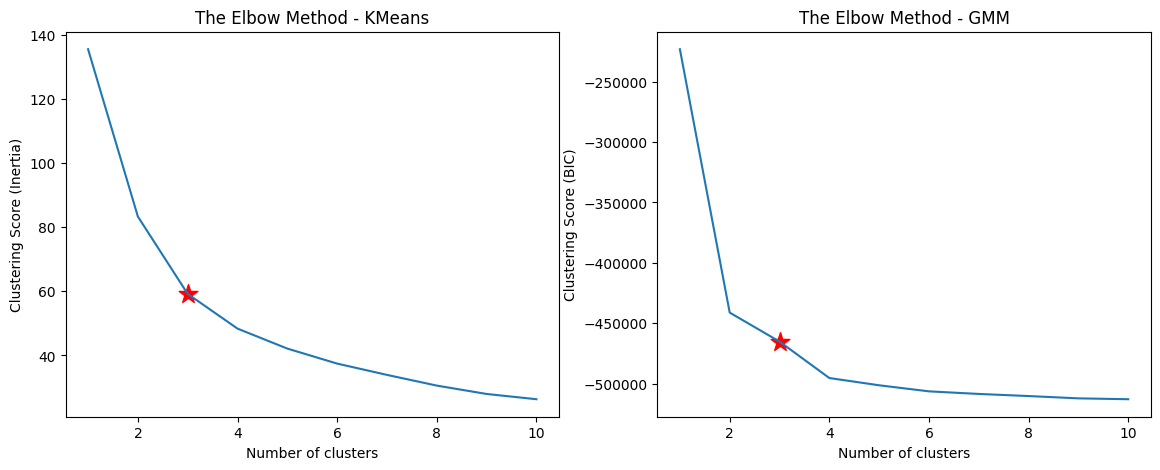

In [11]:
figure, axis = plt.subplots(1, 2, figsize=(14, 5))
axis[0].plot(range(1, 11), kbest_scores)
axis[0].scatter(3, kbest_scores[2], s = 200, c = 'red', marker='*')
axis[0].set_title('The Elbow Method - KMeans')
axis[0].set_xlabel('Number of clusters')
axis[0].set_ylabel('Clustering Score (Inertia)')
axis[1].plot(range(1, 11), gmm_scores)
axis[1].scatter(3, gmm_scores[2], s = 200, c = 'red', marker='*')
axis[1].set_title('The Elbow Method - GMM')
axis[1].set_xlabel('Number of clusters')
axis[1].set_ylabel('Clustering Score (BIC)')
plt.show() 

**Question (optional, to think about): which of these options about the "elbow method" is correct?**

 1. it is always very obvious where the elbow is and therefore which number of clusters to use
    - INCORRECT: This is wrong, it is usually quite unclear where the “elbow” is - here,
you could easily choose 2 or 4 instead of 3.
 2. the "elbow method" is useful as a guideline, but you may have other application-specific reasons for choosing a different number of clusters
    - CORRECT: This is true, the “elbow method” can suggest what might be a good
number of clusters, but you might often have other sorts of reasons for choosing the
number of clusters. For example, a product marketing strategy might want to divide
potential customers up into three ‘clusters’ because they can only produce three different
variants of a product.
 3. the scores for GMM are much lower than KMeans and therefore not much use
    - INCORRECT: This is not true. The absolute values for scores for GMM and KMeans
might be very different, but this is irrelevant - all that matters is where the “elbow” is.

### Analyse one set of clusters in more detail

 * often needs some problem specific code to interpret what the clusters means in human-friendly terms

In [12]:
def list_clusters(method, X, n_clusters, scaler, media_types):
    
    score, centres, labels = method(X, n_clusters)
    
    sizes = pd.Series(labels).value_counts().to_dict()

    media_split = {}
    for i, label in enumerate(labels):
        media_type = media_types[i]
        if label not in media_split:
            media_split[label] = {}
        if media_type not in media_split[label]:
            media_split[label][media_type] = 0
        media_split[label][media_type] += 1

    print('\nThere are {} clusters with a total score of {:.1f}\n'
          .format(len(sizes), score))

    # Re-scale the centres so that they have their original range and
    # put them in a dictionary to identify which variable they relate to
    # so that centres are meaningful

    for label, centre in enumerate(centres):
        centre = {X.columns[i]: 
                  round(centre[i] * scaler.data_range_[i] 
                        + scaler.data_min_[i], 2) for i in range(len(centre))}
        print('Cluster {} has {} posts with media types {} and centre:\n{}\n'
              .format(label, sizes[label], media_split[label], centre))

    return

def plot_clusters(method, X, n_clusters, scaler, media_types, media_to_code):
    
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(projection='3d')
    
    x_axis = 'num_comments'
    y_axis = 'num_likes'
    
    score, centres, labels = method(X, n_clusters)
    
    kwargs = dict(cmap = plt.colormaps['Set1'],
                  edgecolor='none', alpha=1.0)
    N = 10000
    cols = (list(X.columns))
    x = list(X[x_axis] * scaler.data_range_[cols.index(x_axis)])[:N]
    x = [v if v < 6000 else 6000 for v in x]
    plt.xlim([0, 6000])
    
    y = list(X[y_axis] * scaler.data_range_[cols.index(y_axis)])[:N]
    y = [v if v < 3000 else 3000 for v in y]
    plt.ylim([0, 3000])

    z = [media_to_code[m] for m in media_types][:N]
    cols = labels[:N]
    ax.scatter(x, y, z, c=labels[:N], **kwargs)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zticks([0, 1, 2, 3])
    ax.set_zticklabels(media_to_code.keys())




 * let's look at KMeans with 3 clusters

In [13]:
list_clusters(kmeans, X, 3, scaler, media_types)


There are 3 clusters with a total score of 59.2

Cluster 0 has 271 posts with media types {'video': 269, 'photo': 2} and centre:
{'num_comments': 3139.54, 'num_shares': 513.44, 'num_likes': 610.97, 'num_loves': 162.43, 'num_wows': 16.94, 'num_hahas': 8.66, 'num_sads': 1.94, 'num_angrys': 1.27}

Cluster 1 has 6389 posts with media types {'video': 1988, 'photo': 4065, 'link': 49, 'status': 287} and centre:
{'num_comments': 110.8, 'num_shares': 21.5, 'num_likes': 102.78, 'num_loves': 6.97, 'num_wows': 0.56, 'num_hahas': 0.39, 'num_sads': 0.18, 'num_angrys': 0.07}

Cluster 2 has 390 posts with media types {'photo': 221, 'status': 78, 'video': 77, 'link': 14} and centre:
{'num_comments': 58.93, 'num_shares': 14.48, 'num_likes': 1779.01, 'num_loves': 3.01, 'num_wows': 2.35, 'num_hahas': 0.19, 'num_sads': 0.04, 'num_angrys': 0.01}



**Question: looking at the above statistics about the clusters, which of these options is correct?**
 1. The clusters have different mixtures of media types so something is going wrong.
    - INCORRECT: No, it is perfectly OK and expected for each cluster to have a mixture
of media types (recall we are not trying to predict media type here)
 2. The cluster with 271 posts might be characterised as "Highly commented videos"
    - CORRECT: Yes, this seems reasonable; nearly all the posts in this cluster are videos
(269 / 271), with a high number of comments (around 3,000 on average)
 3. The underlying model is 8 Gaussian multivariate distributions one for each of the features like "num_comments" etc.
    - INCORRECT: No, each cluster is associated with one Gaussian (it is the Gaussian
the point is most likely to belong to). So there are three Gaussian distributions here.

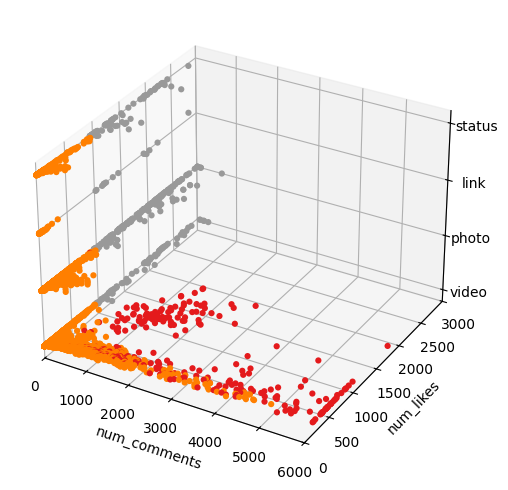

In [14]:
plot_clusters(kmeans, X, 3, scaler, media_types, media_to_code)

**Question (optional, to think about): looking at the above chart, which of these options is correct?**
 1. the grey cluster has relatively high numbers of comments
    - INCORRECT: No, the grey cluster has much lower numbers of comments than the
other two clusters.
 2. num_comments and num_likes are the only possibilities for the x and y axis as they have much larger values than e.g. 'num_wows'
    - INCORRECT: No, you can choose whichever variables you want for the x and y axis
which are appropriate for illustrating a particular point.
 3. it is a bit subjective and application-specific how you visualise the clusters
    - CORRECT: Yes, it very much depends upon the application how you want to visualise
the clusters

* and contrast with GMM and 5 clusters

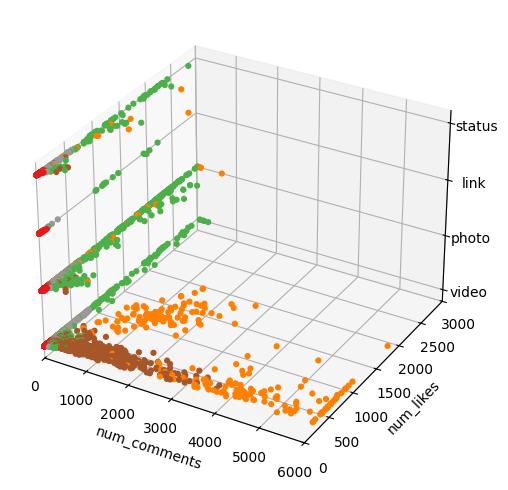

In [15]:
plot_clusters(gmm, X, 5, scaler, media_types, media_to_code)

1. KMeans
    - Assumes spherical, equally sized clusters
    - Uses hard assignment (each point belongs to one cluster)
    - Clusters are clearly separated, but may not match real data shape
    - Z-axis(post_type) clustering appears blocky
    - Simpler and computationally efficient

2. GMM
    - Allows elliptical, overlapping clusters
    - Uses soft assignment (probabilistic membership)
    - Captures nuanced distributions and data spread better
    - Z-axis clustering shows smooth, fine-grained separation
    - More flexible and accurate, but computationally heavier

### Can use PCA to visualise the clusters in 2-D

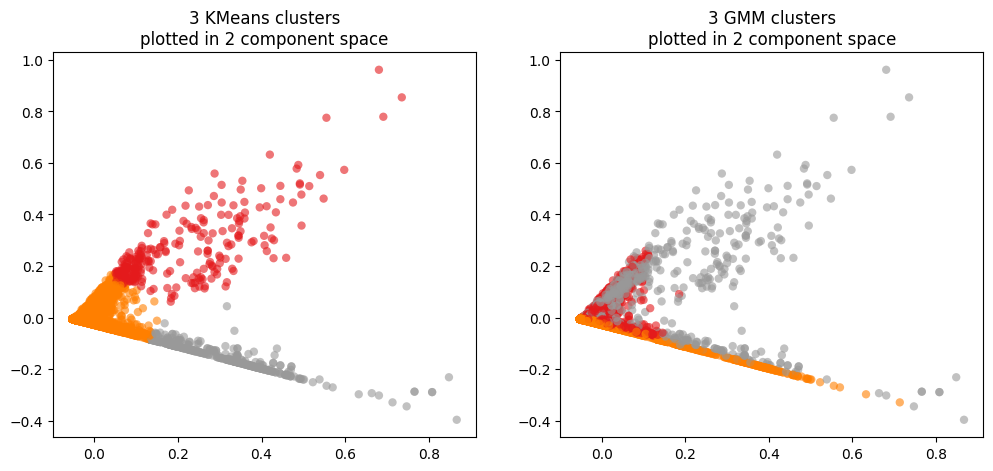

In [16]:
from sklearn.decomposition import PCA

_, _, kmeans_labels = kmeans(X, 3)
_, _, gmm_labels = gmm(X, 3)
X_PCA = PCA(2).fit_transform(X)


kwargs = dict(cmap = plt.colormaps['Set1'],
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X_PCA[:, 0], X_PCA[:, 1], c=kmeans_labels, **kwargs)
ax[0].set_title('3 KMeans clusters\nplotted in 2 component space')

ax[1].scatter(X_PCA[:, 0], X_PCA[:, 1], c=gmm_labels, **kwargs)
ax[1].set_title('3 GMM clusters\nplotted in 2 component space');

**Question (optional, to think about): why are we using PCA here, which of these options is correct?**
 1. We are using PCA for feature selection prior to learning the clusters
    - INCORRECT: No, we are using PCA so we can plot the clusters on a chart, not for
feature reduction or selection.
 2. We are using 2 PCA components because we are comparing two clustering methods
    - INCORRECT: No, we are using 2 PCA components so that we can plot the clusters
on a 2D chart.
 3. The interpretation of these plots is not very clear cut
    - CORRECT: We are using PCA ao we can plot the clusters on a 2D chart. This means
the x-axis now represent components instead of individual variables like numbers of
comments so the chart is harder to interpret.